# Debugging

In [1]:
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain_tavily import TavilySearch
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import BaseMessage
from langchain_core.tools import tool

import os
from dotenv import load_dotenv
load_dotenv("../.env")

True

## Setting up the environment

In [2]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] = os.getenv("LANGSMITH_TRACING")
os.environ["LANGSMITH_PROJECT"] = os.getenv("LANGSMITH_PROJECT")


## Graph with Tool call

In [3]:
# LLM

llm = init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x79afcd700e00>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x79afcd3ee3f0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [4]:
# Tools

@tool
def add(a: int, b: int) -> int:
    """Add two numbers"""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers"""
    return a * b

tavily_search = TavilySearch(max_result = 2)

tools = [add, multiply, tavily_search]
tools

[StructuredTool(name='add', description='Add two numbers', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x79afcd6a07c0>),
 StructuredTool(name='multiply', description='Multiply two numbers', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x79afcfb31940>),
 TavilySearch(api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))]

In [5]:
# Bind LLM with Tools

llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x79afcd700e00>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x79afcd3ee3f0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Add two numbers', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply two numbers', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but of

In [6]:
# Defining State class

class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [7]:
# Node definition

# chatbot (contains llm) node
def chatBot(state: State):
    return {
        'messages': [llm_with_tools.invoke(state['messages'])]
    }
    
# tools node
tools_node = ToolNode(tools)

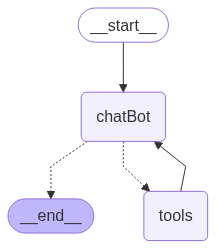

In [8]:
# building graph
builder = StateGraph(State)

# adding node
builder.add_node("chatBot", chatBot)
builder.add_node("tools", tools_node)

# adding edge
builder.add_edge(START, "chatBot")
builder.add_conditional_edges("chatBot", tools_condition)
builder.add_edge("tools", "chatBot")

# compile
graph = builder.compile()
graph

In [12]:
response = graph.invoke({'messages': 'What is the recent AI news?'})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent AI news?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (swrdxhktb)
 Call ID: swrdxhktb
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: week
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Latest AI News: - opentools.ai", "url": "https://opentools.ai/news/ai-spring-2025-major-updates-across-google-openai-microsoft-and-more/AI", "content": "Latest AI News: June 28, 2025 Stay informed with our daily curated artificial intelligence news and insights. We bring you the most important updates in AI, machine learning, and emerging technologies.", "score": 0.7982658, "raw_content": null}, {"title": "Current AI Developments and Business News: Ju

In [11]:
response = graph.invoke({'messages': 'add these two numbers  78 and 67'})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

add these two numbers  78 and 67
================================== Ai Message ==================================
Tool Calls:
  add (94mx5cbjh)
 Call ID: 94mx5cbjh
  Args:
    a: 78
    b: 67
================================= Tool Message =================================
Name: add

145
================================== Ai Message ==================================

<tool-use>{"tool_calls":[]}</tool-use>


In [13]:
response = graph.invoke({'messages': 'Search for the F1 movie release in 2025 and provide me the details'})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Search for the F1 movie release in 2025 and provide me the details
================================== Ai Message ==================================
Tool Calls:
  tavily_search (d59g656a4)
 Call ID: d59g656a4
  Args:
    exclude_domains: []
    include_domains: []
    include_images: False
    query: F1 movie release 2025
    search_depth: advanced
    time_range: None
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "F1 movie release 2025", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/F1_(film)", "title": "F1 (film) - Wikipedia", "content": "| Production companies |  Apple Studios  Monolith Pictures  Jerry Bruckheimer Films  Plan B Entertainment  Dawn Apollo Films |\n| Distributed by |  Warner Bros. Pictures  Apple Original Films |\n| Release dates |  June 16, 

In [17]:
response = graph.invoke({'messages': 'Tell me latest news about Agentic Ai. add these two numbers 89 and 56. Multiply these two numbers 7 and 67'})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Tell me latest news about Agentic Ai. add these two numbers 89 and 56. Multiply these two numbers 7 and 67
================================== Ai Message ==================================
Tool Calls:
  tavily_search (98aan8dw7)
 Call ID: 98aan8dw7
  Args:
    query: Agentic AI latest news
    search_depth: advanced
    topic: news
  add (38k2zthmd)
 Call ID: 38k2zthmd
  Args:
    a: 89
    b: 56
  multiply (3dj7fng0w)
 Call ID: 3dj7fng0w
  Args:
    a: 7
    b: 67
================================= Tool Message =================================
Name: tavily_search

{"query": "Agentic AI latest news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.rcrwireless.com/20250627/business/agentic-ai-gartner", "title": "Gartner: More than 40% of agentic AI projects will fail by 2027 - RCR Wireless News", "score": 0.7803451, "published_date": "Fri, 27 Jun 2025 14:42:59 GMT